In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Embedding
from keras.layers import BatchNormalization
from keras.utils import np_utils
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.utils import pad_sequences
from keras.initializers import Constant
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
import gensim
from preprocessing import preprocess
import nltk
nltk.download('punkt')
print(tf.__version__)

2.11.0


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahmed\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [69]:
df_train = preprocess('2018-E-c-Ar-train.xlsx')
df_test = preprocess('2018-E-c-Ar-test-gold.xlsx')

In [70]:
x_train = df_train["Tweet"]
y_train_pre = df_train.drop(["ID","Tweet"],axis=1)
x_test = df_test["Tweet"]
y_test_pre = df_test.drop(["ID","Tweet"],axis=1)

In [4]:
y_train = np.asarray(y_train_pre.values.tolist())
y_test = np.asarray(y_test_pre.values.tolist())

In [68]:
t_model = gensim.models.Word2Vec.load('full_uni_sg_100_twitter/full_uni_sg_100_twitter.mdl')


In [71]:
EMBEDDING_DIMENSION = 100
VOCABULARY_SIZE = 22000
MAX_LENGTH = 26
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [72]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE)
tokenizer.fit_on_texts(list(x_train) + list(x_test))

In [73]:
xtrain_sequences = tokenizer.texts_to_sequences(x_train)
xtest_sequences = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))
dict(list(word_index.items())[0:10])

Vocabulary size: 21178


{'الله': 1,
 'اللي': 2,
 'انا': 3,
 'مش': 4,
 'ان': 5,
 'والله': 6,
 'مو': 7,
 'الي': 8,
 'شي': 9,
 'الناس': 10}

In [74]:
num_words = len(word_index)+1
embedding_matrix = np.zeros((num_words,EMBEDDING_DIMENSION))

for word,i in word_index.items():
    if i > num_words:
        continue
    try:
        embedding_vector = t_model.wv[word]
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    except: 
        continue


In [75]:
print(xtrain_sequences[100])

[119, 3312, 400, 124]


In [76]:
xtrain_pad = pad_sequences(xtrain_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
xtest_pad = pad_sequences(xtest_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
print(len(xtrain_sequences[0]))
print(len(xtrain_pad[0]))
print(xtrain_pad[100])

20
26
[ 119 3312  400  124    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [77]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [79]:
# arr1 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr2 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr3 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr4 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# arr5 = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# bestSpatial = 0
# bestlstmdrop = 0
# bestlstmrecurrent = 0
# bestdropout1 = 0
# bestdropout2 = 0
# bestAccuracy = 0
# for i in arr1:
#     for j in arr2:
#         for k in arr3:
#             for l in arr4:
#                 for m in arr5:
model = Sequential()
model.add(Embedding(num_words,EMBEDDING_DIMENSION,embeddings_initializer=Constant(embedding_matrix),input_length=MAX_LENGTH))
# model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(EMBEDDING_DIMENSION, dropout=0.3, recurrent_dropout=0.2)))
model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
# model.add(Dropout(0.3))
# model.add(Dense(EMBEDDING_DIMENSION, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(11))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['acc',f1_m,precision_m,recall_m])
num_epochs = 20
history = model.fit(xtrain_pad, y_train, epochs=num_epochs, verbose=1)
                    # loss, accuracy = model.evaluate(xtest_pad, y_test, verbose=0)
                    # if accuracy > bestAccuracy:
                    #     bestAccuracy = accuracy
                    #     bestSpatial = i
                    #     bestlstmdrop = j
                    #     bestlstmrecurrent = k
                    #     bestdropout1 = l
                    #     bestdropout2 = m


Epoch 1/20
72/72 [==============================] - 45s 522ms/step - loss: 0.4690 - acc: 0.3521 - f1_m: 0.0209 - precision_m: 0.1898 - recall_m: 0.0113
Epoch 2/20
72/72 [==============================] - 39s 540ms/step - loss: 0.3648 - acc: 0.4561 - f1_m: 0.1897 - precision_m: 0.8204 - recall_m: 0.1092
Epoch 3/20
72/72 [==============================] - 38s 526ms/step - loss: 0.3230 - acc: 0.5219 - f1_m: 0.2928 - precision_m: 0.8798 - recall_m: 0.1773
Epoch 4/20
72/72 [==============================] - 38s 523ms/step - loss: 0.2859 - acc: 0.5847 - f1_m: 0.3954 - precision_m: 0.9090 - recall_m: 0.2539
Epoch 5/20
72/72 [==============================] - 39s 537ms/step - loss: 0.2573 - acc: 0.6036 - f1_m: 0.4489 - precision_m: 0.9217 - recall_m: 0.2984
Epoch 6/20
72/72 [==============================] - 36s 494ms/step - loss: 0.2289 - acc: 0.6299 - f1_m: 0.5016 - precision_m: 0.9481 - recall_m: 0.3419
Epoch 7/20
72/72 [==============================] - 36s 496ms/step - loss: 0.2041 - acc:

In [80]:
loss, accuracy, f1, precision, recall = model.evaluate(xtest_pad, y_test, verbose=0)

In [81]:
print("Accuracy: ",accuracy)
print("Precision: ",precision)
print("Recall: ",recall)
print("F1 Score: ",f1)


Accuracy:  0.4953886568546295
Precision:  0.7673709392547607
Recall:  0.31800878047943115
F1 Score:  0.4489719569683075


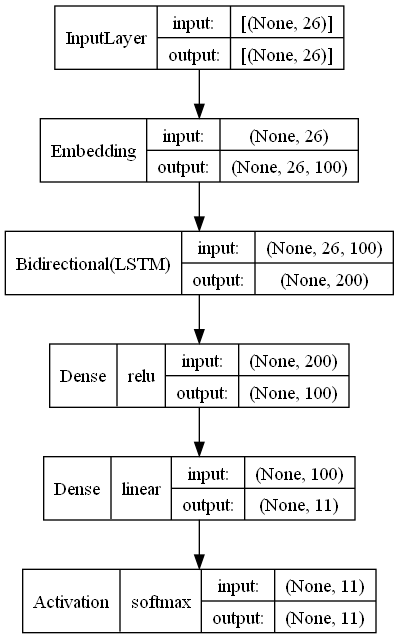

In [82]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)


In [84]:
model.save("LSTM_Model_Final.h5")